(sec-tutorial-conditional-reset)=


```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Conditional Reset.ipynb`

```

# Tutorial: Conditional Reset

In this tutorial, we show how to perform a conditional reset using the [conditional control flow framework](sec-control-flow). A conditional reset consists of measuring the state of a qubit, and then:
- sending a pulse to rotate the qubit to the ground state in case the qubit is found to be in an excited state
- not sending any pulse if the qubit is found to be in the ground state

This conditional reset is potentially much faster than an idle qubit reset (i.e. waiting for a time {math}`\gg \tau_1`).
Quantify discriminates between excited and ground state at the `Measure` operation using a [thresholded acquisition](thresholded_acquisition_explanation), and uses a default {math}`\pi` pulse to set the qubit to its ground state.
In this tutorial, we demonstrate conditional reset using a Qblox cluster that contains a readout module (`QRM_RF`), responsible for the measurement of the qubit, and a control module (`QCM_RF`), responsible for conditionally sending out the {math}`\pi` pulse.

To run a conditional reset, we perform the following steps:

1. Set up the quantum device, dummy hardware, and hardware configuration.
2. Configure thresholded acquisition parameters to separate the {math}`|0\rangle` and {math}`|1\rangle` states.
3. Verify that these parameters are set correctly.
4. Run a conditional reset.


```{note}
Currently, the conditional reset is only implemented for the Qblox hardware.
```

(cond_reset_initial_setup)=

## Initial Setup

We follow here the same setup as in the {ref}`sec-tutorial-experiment` tutorial.

First, we define a single transmon qubit as an element ({{ BasicTransmonElement }}) of the {{ QuantumDevice }} and populate the parameters with some reasonable values:

```{seealso}
If you want to learn more about how to set up the {{ QuantumDevice }} and hardware configuration, please see our other tutorials, in particular {ref}`sec-tutorial-experiment` and {ref}`sec-tutorial-compiling`.
```

In [1]:
"""Disable transparent backgrounds for analysis figures to make them look nicer
in both dark and bright mode on the website."""

from quantify_core.analysis import base_analysis as ba

ba.settings["mpl_transparent_background"] = False

In [2]:
from qblox_instruments import Cluster, ClusterType
import tempfile

from quantify_core.data import handling as dh
from quantify_core.measurement.control import MeasurementControl
from quantify_scheduler.device_under_test.quantum_device import QuantumDevice
from quantify_scheduler.device_under_test.transmon_element import BasicTransmonElement
from quantify_scheduler.instrument_coordinator import InstrumentCoordinator
from quantify_scheduler.instrument_coordinator.components.qblox import ClusterComponent

measurement_control = MeasurementControl("measurement_control")
instrument_coordinator = InstrumentCoordinator("instrument_coordinator")

# Create a temporary directory for this tutorial
temp_dir = tempfile.mkdtemp()

# First, don't forget to set the data directory!
dh.set_datadir(temp_dir)

# Device parameters
ACQ_DELAY = 100e-9
FREQ_01 = 4e9
READOUT_AMP = 0.1
READOUT_FREQ = 4.3e9
PI_PULSE_AMP = 0.15
LO_FREQ_QUBIT = 3.9e9
LO_FREQ_READOUT = 4.5e9

single_qubit_device = QuantumDevice("single_qubit_device")

q0 = BasicTransmonElement("q0")
single_qubit_device.add_element(q0)

# Assign device parameters to transmon element
q0.measure.pulse_amp(READOUT_AMP)
q0.clock_freqs.readout(READOUT_FREQ)
q0.clock_freqs.f01(FREQ_01)
q0.measure.acq_delay(ACQ_DELAY)
q0.rxy.amp180(PI_PULSE_AMP)

Next, we connect to a dummy {{ Cluster }}. If you are connecting to an actual cluster, you would provide the
 `identifier` argument (the IP address, device name or serial number) instead
 of the `dummy_cfg` argument.

In [3]:
cluster = Cluster(
    "cluster",
    dummy_cfg={
        1: ClusterType.CLUSTER_QRM_RF,
        2: ClusterType.CLUSTER_QCM_RF,
    },
)

ic_cluster = ClusterComponent(cluster)

instrument_coordinator.add_component(ic_cluster)

single_qubit_device.instr_instrument_coordinator(instrument_coordinator.name)

Finally, we define the hardware configuration:

In [4]:
hardware_cfg = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        f"{cluster.name}": {
            "instrument_type": "Cluster",
            "modules": {
                1: {"instrument_type": "QRM_RF"},
                2: {"instrument_type": "QCM_RF"},
            },
            "ref": "internal",
        }
    },
    "hardware_options": {
        "modulation_frequencies": {
            "q0:res-q0.ro": {"lo_freq": LO_FREQ_READOUT},
            "q0:mw-q0.01": {"lo_freq": LO_FREQ_QUBIT},
        }
    },
    "connectivity": {
        "graph": [
            (f"{cluster.name}.module1.complex_output_0", "q0:res"),
            (f"{cluster.name}.module2.complex_output_0", "q0:mw"),
        ]
    },
}

single_qubit_device.hardware_config(hardware_cfg)

(cond_reset_create_schedule)=

## Readout Calibration

To discriminate between the ground state and the excited state with {{ ConditionalReset }}, we first need to configure the {{ ThresholdedAcquisition }} parameters `acq_threshold` and `acq_rotation` (see [Tutorial: Acquisitions](thresholded_acquisition_explanation)). We do so by preparing a qubit in either its ground state or its excited state, performing a measurement, and repeating this process 500 times. In the measured IQ plane we expect to find all data points clustered in two distinct groups that correspond to the two different states, and the `acq_threshold` and `acq_rotation` parameters define the line between the two groups. 

We run this calibration using {{ MeasurementControl }} and a predefined {{ Schedule }} called {{ readout_calibration_sched }}:

In [5]:
### Generate dummy data

import numpy as np
from qblox_instruments.ieee488_2.dummy_transport import DummyBinnedAcquisitionData
from quantify_scheduler.helpers.qblox_dummy_instrument import (
    start_dummy_cluster_armed_sequencers,
)

def get_dummy_binned_acquisition_data(
    real: float, imag: float, theta: float, threshold: float
):
    angle = 2 * np.pi * theta / (360)
    threshold *= 1000 # different normalization (integration length) on qblox instruments
    if real * np.cos(angle) + imag * np.sin(angle) > -threshold:
        thres = 0
    else:
        thres = 1
    return DummyBinnedAcquisitionData(data=(real, imag), thres=thres, avg_cnt=0)


# Means and standard deviations
x0, xs0 = -2.7, 2.5
y0, ys0 = 2.9, 2.5
x1, xs1 = -14, 2.5
y1, ys1 = 1.9, 2.5

# Number of points per data cluster
n_points = 500

# Generate random samples
x0_samples = np.random.normal(x0, xs0, n_points)
y0_samples = np.random.normal(y0, ys0, n_points)
x1_samples = np.random.normal(x1, xs1, n_points)
y1_samples = np.random.normal(y1, ys1, n_points)

# interleave the random samples such that we get
# x = [x0_samples[0], x1_samples[0], x0_samples[1],...]
# y = [y0_samples[0], y1_samples[0], y0_samples[1],...]

x = np.vstack((x0_samples, x1_samples)).reshape(-1, order="F")
y = np.vstack((y0_samples, y1_samples)).reshape(-1, order="F")
states = np.array([0, 1] * 500)

# prepare cluster with dummy data that will be returned 
# after retrieving acquisitions.
cluster.delete_dummy_binned_acquisition_data(1)
cluster.set_dummy_binned_acquisition_data(
    slot_idx=1,
    sequencer=0,
    acq_index_name="0",
    data=[
        get_dummy_binned_acquisition_data(float(re), float(im), 0, 0)
        for re, im in zip(x, y)
    ],
)

cluster.start_sequencer = lambda: start_dummy_cluster_armed_sequencers(ic_cluster)

In [6]:
import numpy as np
from qcodes import ManualParameter

from quantify_scheduler.gettables import ScheduleGettable
from quantify_scheduler.operations.gate_library import Measure
from quantify_scheduler.schedules.schedule import Schedule
from quantify_scheduler.schedules.timedomain_schedules import readout_calibration_sched


single_qubit_device.cfg_sched_repetitions(1)

states = ManualParameter(name="States", unit="", label="")
states.batched = True

prepared_states = np.asarray([0, 1] * 500)
readout_calibration_kwargs = {"qubit": "q0", "prepared_states": prepared_states}
gettable = ScheduleGettable(
    single_qubit_device,
    schedule_function=readout_calibration_sched,
    schedule_kwargs=readout_calibration_kwargs,
    real_imag=True,
    batched=True,
    max_batch_size=200,
)

measurement_control.settables(states)
measurement_control.setpoints(prepared_states)
measurement_control.gettables(gettable)
measurement_control.verbose(False)

dataset = measurement_control.run("Readout Calibration")
dataset

<xarray.Dataset> Size: 24kB
Dimensions:  (dim_0: 1000)
Coordinates:
    x0       (dim_0) int64 8kB 0 1 0 1 0 1 0 1 0 1 0 1 ... 1 0 1 0 1 0 1 0 1 0 1
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 8kB -0.0004568 -0.01343 ... -0.001208 -0.009998
    y1       (dim_0) float64 8kB 0.006868 0.005883 ... 0.003216 -0.0008591
Attributes:
    tuid:                             20241014-165455-111-6672b9
    name:                             Readout Calibration
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

```{seealso}
More information on configuring {{ MeasurementControl }} can be found in the
[user guide](https://quantify-os.org/docs/quantify-core/dev/user/concepts.html#measurement-control)
of `quantify-core`, and in the tutorials [Running and Experiment](sec-tutorial-experiment) and [ScheduleGettable](sec-schedulegettable-2dsweep-usage)
```

To determine the qubit threshold parameters, we use the {{ ReadoutCalibrationAnalysis }}:

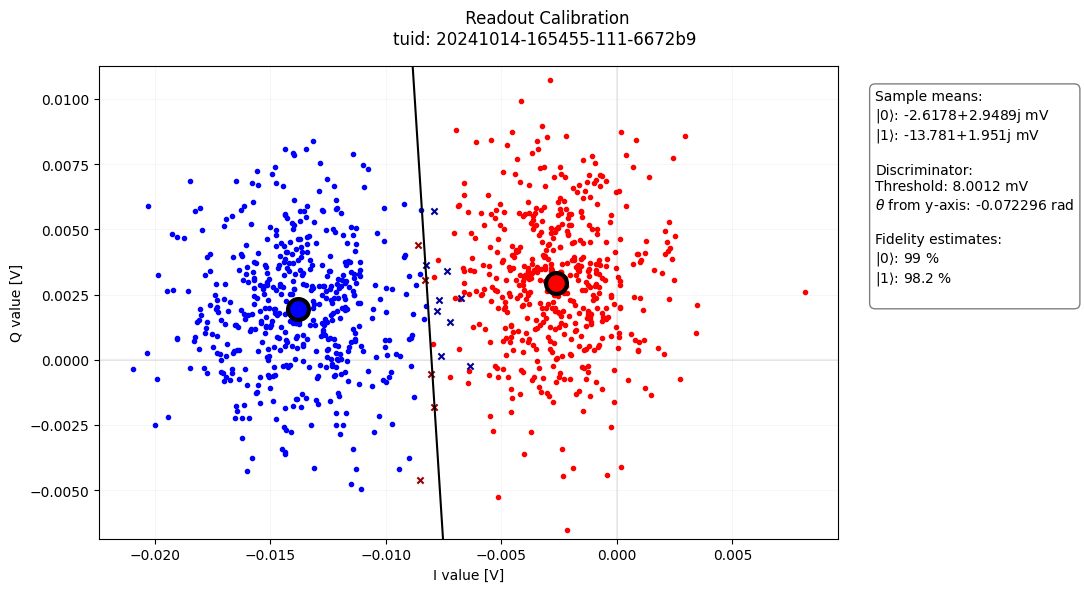

In [7]:
from quantify_core.analysis.readout_calibration_analysis import (
    ReadoutCalibrationAnalysis,
)

analysis = ReadoutCalibrationAnalysis(dataset)
analysis.run()
analysis.display_figs_mpl()

The image above shows that the measured IQ points are clustered in two groups as expected. We can now fit a line between the two groups and from there obtain the `acq_threshold` and the `acq_rotation` parameters, that we add to the qubit configuration:

In [8]:
import numpy as np

fit_results = analysis.fit_results["linear_discriminator"].params
acq_threshold = fit_results["acq_threshold"].value
acq_rotation = (np.rad2deg(fit_results["acq_rotation_rad"].value)) % 360

q0.measure.acq_threshold(acq_threshold)
q0.measure.acq_rotation(acq_rotation)

## Verifying parameters

We can quickly verify that the qubit parameters are set correctly by running again the {{ readout_calibration_sched }} schedule with `"ThresholdedAcquisition"` as acquisition protocol. If the calibration was done correctly, we expect that when the state is prepared in the {math}`|0\rangle` state or {math}`|1\rangle` state, the thresholded acquisition will return 0 or 1 respectively. The results are then verified using a confusion matrix:

In [9]:
cluster.delete_dummy_binned_acquisition_data(1)
cluster.set_dummy_binned_acquisition_data(
    slot_idx=1,
    sequencer=0,
    acq_index_name="0",
    data=[
        get_dummy_binned_acquisition_data(
            float(re), float(im), acq_rotation, acq_threshold
        )
        for re, im in zip(x, y)
    ],
)

cluster.start_sequencer = lambda: start_dummy_cluster_armed_sequencers(ic_cluster)

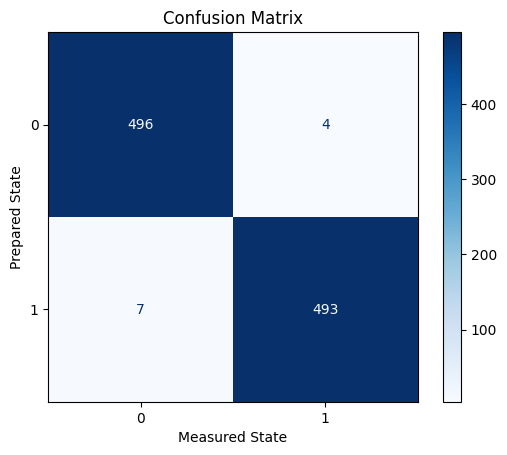

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

single_qubit_device.cfg_sched_repetitions(1)

states = ManualParameter(name="States", unit="", label="")
states.batched = True

prepared_states = np.asarray([0, 1] * 500)
readout_calibration_kwargs = {
    "qubit": "q0",
    "prepared_states": prepared_states,
    "acq_protocol": "ThresholdedAcquisition",
}

gettable = ScheduleGettable(
    single_qubit_device,
    schedule_function=readout_calibration_sched,
    schedule_kwargs=readout_calibration_kwargs,
    real_imag=True,
    batched=True,
    max_batch_size=200,
)

measurement_control.settables(states)
measurement_control.setpoints(prepared_states)
measurement_control.gettables(gettable)
dataset = measurement_control.run("Readout Calibration Verification")

prepared_states = dataset.x0.values
measured_states = dataset.y0.values

ConfusionMatrixDisplay.from_predictions(
    prepared_states, measured_states, cmap="Blues", normalize=None
)
plt.title("Confusion Matrix")
plt.xlabel("Measured State")
plt.ylabel("Prepared State")

plt.show()

As expected, the threshold that we set did a good job of discriminating the qubit states (the discrimination is not perfect because the data points belonging to the two states slightly overlap).

## Conditional Reset

The conditional reset is implemented in Quantify as a gate. When we have a single {{ Reset }} at the beginning of a schedule, we simply replace the {{ Reset }} gate with the {{ ConditionalReset }} gate, for example

```{code-block} python
schedule = Schedule()
#schedule.add(Reset("q0"))
schedule.add(ConditionalReset("q0"))
...
```

In other cases, however, we need to pass extra arguments to {{ ConditionalReset }} that we illustrate below.

### Example: Modifying the T1 schedule

In this example, we use the schedule function {{ t1_sched }} using the {{ ConditionalReset }} instead of the standard {{ Reset }}. When using multiple consecutive {{ ConditionalReset }} on the same qubit, we need to increment the `acq_index` for each one, similar to when adding multiple {{ Measure }} to the schedule. We also need to ensure that all acquisition protocols in the schedule are equal to `"ThresholdedAcquisition"`.

In [11]:
from quantify_scheduler.backends.qblox.operations.gate_library import ConditionalReset
from quantify_scheduler.operations.gate_library import X, Reset


# original T1 schedule
def t1_sched(
    times: np.ndarray,
    qubit: str,
    repetitions: int = 1,
) -> Schedule:

    schedule = Schedule("T1", repetitions)
    for i, tau in enumerate(times):
        schedule.add(Reset(qubit), label=f"Reset {i}")
        schedule.add(X(qubit), label=f"pi {i}")
        schedule.add(
            Measure(qubit, acq_index=i),
            ref_pt="start",
            rel_time=tau,
            label=f"Measurement {i}",
        )
    return schedule


# updated T1 schedule
def t1_sched(
    times: np.ndarray,
    qubit: str,
    repetitions: int = 1,
) -> Schedule:

    schedule = Schedule("T1", repetitions)
    for i, tau in enumerate(times):
        schedule.add(
            ConditionalReset(qubit, acq_index=i, acq_channel=0),
            label=f"Reset {i}",
        )
        schedule.add(X(qubit), label=f"pi {i}")
        schedule.add(
            Measure(
                qubit,
                acq_index=i,
                acq_protocol="ThresholdedAcquisition",
                acq_channel=1,
            ),
            ref_pt="start",
            rel_time=tau,
            label=f"Measurement {i}",
        )
    return schedule

#### Running the T1 schedule using MeasurementControl

The dataset returned by {{ MeasurementControl }} will in this case have four rows of data, which are: 
- `y0`: contains the data establishing whether a qubit was reset or not
- `y1`: contains the actual (thresholded) measurement
- `y2` and `y3`: filled with NaNs (currently {{ MeasurementControl }} expects {{ ScheduleGettable }} to return IQ values)

Below we run {{ MeasurementControl }} again as before

In [12]:
## generate dummy data for a fictitious T1 experiment

import numpy as np

tau = 1e-5
runs = 1024
times = np.array(list(np.linspace(start=1.6e-7, stop=4.976e-5, num=125)))
num_samples = len(times)

random_initial_states = np.mean(
    np.random.choice([0, 1], num_samples * runs).reshape(num_samples, runs), axis=1
)


def generate_random_numbers(times, tau, runs):
    times = np.array(times)

    probabilities = np.exp(-times / tau)

    random_results = np.random.rand(runs, len(times)) < probabilities
    average_results = random_results.mean(axis=0)

    return average_results


average_T1_data = generate_random_numbers(times, tau, runs)

cluster.delete_dummy_binned_acquisition_data(1)

ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=1,
    sequencer=0,
    acq_index_name=f"0",
    data=[
        DummyBinnedAcquisitionData(data=(0, 0), thres=x, avg_cnt=0)
        for x in random_initial_states
    ],
)

ic_cluster.instrument.set_dummy_binned_acquisition_data(
    slot_idx=1,
    sequencer=0,
    acq_index_name=f"1",
    data=[
        DummyBinnedAcquisitionData(data=(0, 0), thres=x, avg_cnt=0)
        for x in average_T1_data
    ],
)

cluster.start_sequencer = lambda: start_dummy_cluster_armed_sequencers(ic_cluster)

In [13]:
single_qubit_device.cfg_sched_repetitions(1024)  # run and average 1024 times

# Configure the settable
time = ManualParameter("sample", label="Sample time", unit="s")
time.batched = True

times = np.array(list(np.linspace(start=1.6e-7, stop=4.976e-5, num=125)))

# Configure the gettable
gettable = ScheduleGettable(
    quantum_device=single_qubit_device,
    schedule_function=t1_sched,
    schedule_kwargs={"qubit": "q0", "times": times},
    batched=True,
    num_channels=2,
)

# Configure MeasurementControl
measurement_control.settables(time)
measurement_control.setpoints(times)
measurement_control.gettables(gettable)

dataset = measurement_control.run("t1")

In [14]:
# we need to temporarily patch the dataset because I don't understand how to
# pass average thresholds to DummyBinnedAcquisitionData such that
# ScheduleGettable returns floats instead of ints
dataset.y0.values = random_initial_states
dataset.y1.values = average_T1_data

Above we also passed `num_channels=2` to the {{ ScheduleGettable }} so that it knows to expect measurements on the same qubit, but separate acquisition channels.

We now plot the contents of this dataset:

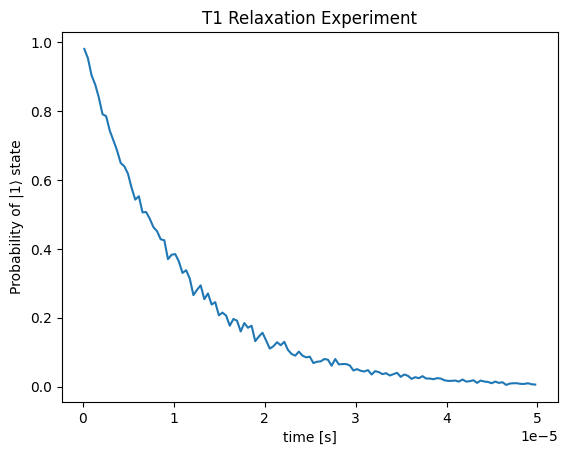

In [15]:
plt.plot(dataset.x0, np.abs(dataset.y1))
plt.xlabel("time [s]")
plt.ylabel('Probability of |1⟩ state')
plt.title('T1 Relaxation Experiment')
plt.show()

```{note}
Often, we can use an `Analysis` class on datasets to visualize the data and extract relevant parameters such as {{ T1Analysis }}
```

### Note on Execution Order

Parallel {{ ConditionalReset }} operations are not supported. For example, compiling the following schedule will raise a {{ RuntimeError }}:

```{code-block} python
schedule = Schedule("")
schedule.add(ConditionalReset("q0"))
schedule.add(ConditionalReset("q1"), ref_pt="start")
```

and will have to be scheduled sequentially,

```{code-block} python
schedule = Schedule("")
schedule.add(ConditionalReset("q0"))
schedule.add(ConditionalReset("q1"))
```


## Closing Remarks

You can find more technical information and explanations of the different limitations in our [reference guide](sec-qblox-conditional-playback).